# Question 2: applied ML

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from pprint import pprint
%matplotlib inline

## Preprocessing of the newspaper dataset

#### Loading of the newspaper dataset

Firstly we load the newspaper standard dataset from the sklearn library and we print the newspapers categories (targets) that are used for classification in this problem.

In [6]:
newsgroups= fetch_20newsgroups(subset ='all')
pprint(type(newsgroups))
pprint(dir(newsgroups))
len(newsgroups.target)

<class 'sklearn.utils.Bunch'>
['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


18846

#### Training, validation and test set generation

In this part we randomly divide the dataset in three parts as follows:
- Train set: constituting 80% of the original dataset
- Validation set: constituting 10% of the original dataset
- Test set: constituting 10% of the original dataset

Firstly we get the number of data that will be in each set.

In [7]:
train_ratio = 0.8
test_ratio = 0.1
valid_ratio = 0.1

data_len = len(newsgroups.filenames)
train_len = int(np.floor(train_ratio*data_len))
test_len = int(np.floor(test_ratio*data_len))
valid_len = int(data_len - (train_len + test_len))

Then we use the shuffle function from the random package to shuffle indices and therefore to randomly attribute the observed data to each of the three subsets.

In [8]:
from random import shuffle

rand_articles = [i for i in range(data_len)]
shuffle(rand_articles)

train_subset = rand_articles[0:train_len]
test_subset = rand_articles[train_len:train_len+test_len]
valid_subset = rand_articles[train_len+test_len:]

#### TF-IDF computation

Now we compute the TF-IDF statistic for the newspaper dataset. To do so we use the `TfidfVectorizer()` function from the `sklearn` library.

In [9]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)


In the following part we just assign the vectors obtained in the previous step to the train, test and training set.

In [10]:
train_vectors = vectors[train_subset,:]
test_vectors = vectors[test_subset,:]
valid_vectors = vectors[valid_subset,:]

train_target = [newsgroups.target[w] for w in train_subset]
test_target = [newsgroups.target[w] for w in test_subset]
valid_target = [newsgroups.target[w] for w in valid_subset]

## Random Forest Training 

#### Grid search

Now we compute train a random forest classifier for different combination of parameters. The parameters that are investigated are:
- The number of decision trees generated in order to build the random forest.
- The maximum depth of each of those decision trees

To do so we implement a grid search over the parameters. Therefore we train a random forest for each parameter combination in a two nested for loops. While training random forests for the different combinations of parameters we also compute the train score and the validation score. The validation score will be useful afterwards to select the parameter combination that yields the best prediction. 

The score computed in this part is the default score implemented in the sklearn classifier for Random Forests: it is the mean accuracy.

In [ ]:
parameters = {'n_estimators': [100, 300, 400, 500] , 'max_depth':[25, 30, 35, 40, 45]}
train_score = np.zeros((len(parameters['n_estimators']), len(parameters['max_depth'])))
valid_score = np.zeros((len(parameters['n_estimators']), len(parameters['max_depth'])))

for index_estim, n_estimators in enumerate(parameters['n_estimators']):
    for index_depth, max_depth in enumerate(parameters['max_depth']):
        rand_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, verbose = 1)
        rand_forest.fit(train_vectors, train_target)
        train_score[index_estim, index_depth] = rand_forest.score(train_vectors, train_target)
        valid_score[index_estim, index_depth] = rand_forest.score(valid_vectors, valid_target)

The scores obtained for the training set and the test set are the following:

In [170]:
valid_score

array([[ 0.78791092,  0.79639449,  0.80911983,  0.80752916,  0.83032874],
       [ 0.81866384,  0.82290562,  0.83297985,  0.84623542,  0.83510074],
       [ 0.8107105 ,  0.82661718,  0.83616119,  0.84040297,  0.84305408],
       [ 0.81707317,  0.82767762,  0.83351007,  0.84146341,  0.84358431]])

In [171]:
train_score

array([[ 0.92212789,  0.94229239,  0.96146193,  0.97187583,  0.97850889],
       [ 0.93924118,  0.95986999,  0.96948793,  0.98049881,  0.9854736 ],
       [ 0.94202706,  0.9588087 ,  0.97346776,  0.97943752,  0.98600425],
       [ 0.94269037,  0.95927302,  0.97068188,  0.98023348,  0.98560626]])

#### Heat maps of the scores

Now we plot both the validation score and the train score thanks to heat maps. The validation is going to help us choosing the combination of parameters that maximizes the mean accuracy. The train score heat map is just plot to confirm that the train error decreases as both the max tree depth and the number of trees increase.

In [47]:
plt.figure()
plt.imshow(valid_score, cmap='hot')
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.title('Validation score')
#plt.xticks(parameters['max_depth'])
#plt.yticks(parameters['n_estimators'])

plt.figure()
plt.imshow(train_score, cmap='hot')
plt.xlabel('depth')
plt.ylabel('number of estimators')
plt.xlabel(parameters['n_estimators'])
plt.title('Train score')

NameError: name 'valid_score' is not defined

#### Parameter selection

The cell below show that over the tested parameters, the combination that yields the least validation error is:
- Best number of trees: 300
- Best maximal tree depth: 40

In [11]:
ravel_index = np.argmax(valid_score)
best_n_estimators_index = int(ravel_index / valid_score.shape[1])
best_max_depth = ravel_index % valid_score.shape[1]

best_n_estimators = parameters['n_estimators'][best_n_estimators_index]
best_max_depth = parameters['max_depth'][best_max_depth]

print('The best number of trees is:', best_n_estimators)
print('The best maximal tree depth is:', best_max_depth)

NameError: name 'valid_score' is not defined

#### Pseudo optimal random forest training

Now we train again a random forest classifier on our training data with those pseudo optimal parameters in order to be able to carry out prediction with it.

In [13]:
best_n_estimators = 300
best_max_depth = 40

In [14]:
opt_rand_forest = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, verbose = 1)
opt_rand_forest.fit(train_vectors, train_target)

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

#### Test score

Now we are able to compute the score of the optimized random forest.

In [15]:
test_score = opt_rand_forest.score(test_vectors, test_target)
test_score

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished


0.83651804670912955

In [43]:
y_pred_test = opt_rand_forest.predict(test_vectors)
confusion_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred_test, labels=range(20), sample_weight=None)
confusion_matrix

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished


array([[ 68,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   8,   0,   3,   0,   1],
       [  0,  75,   7,   3,   2,   3,  11,   1,   0,   0,   0,   0,   1,
          1,   2,   0,   1,   0,   0,   0],
       [  0,   5, 107,   4,   0,   4,   3,   0,   0,   0,   0,   0,   0,
          0,   2,   0,   0,   0,   0,   0],
       [  0,   5,   4,  62,   6,   1,   7,   1,   0,   0,   0,   0,   3,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   3,   4,  75,   0,   7,   1,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   8,   1,   1,   0,  73,   2,   0,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   2,   1,   0,   0,  86,   1,   1,   0,   0,   0,   0,
          1,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1,   5,  82,   2,   0,   0,   0,   1,
          0,   2,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   7,   1,  97,   0,   0,  

In [44]:
len(labels)

20

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


AttributeError: 'AxesImage' object has no attribute 'set_xticklabels'

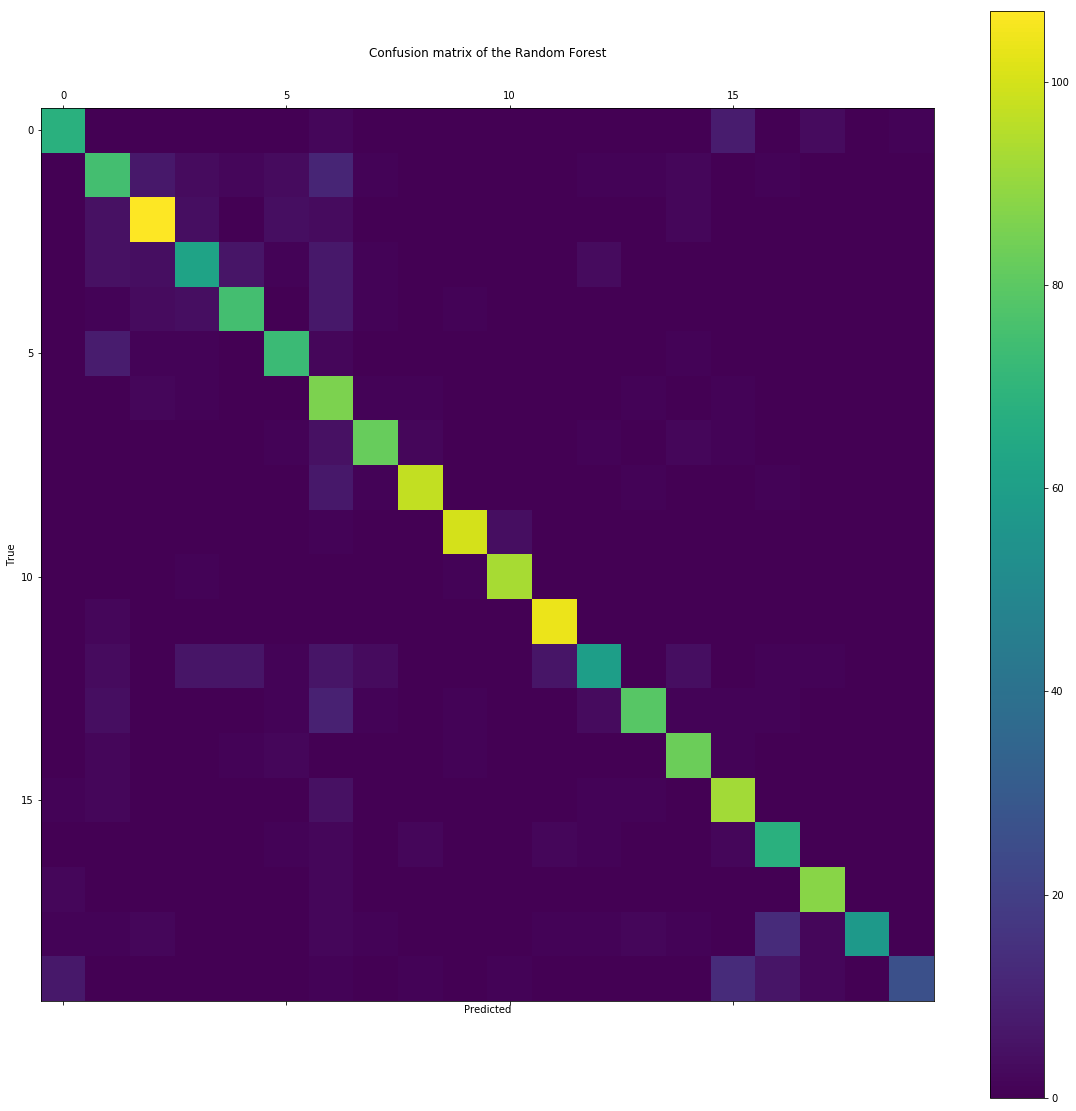

In [46]:
labels = list(newsgroups.target_names)
print(labels)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
plot = ax.matshow(confusion_matrix)
fig.colorbar(plot)
plt.title('Confusion matrix of the Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plot.set_xticklabels(labels)
#plt.xticks(['']+labels)

In [179]:
opt_rand_forest.feature_importances_

array([  3.46901256e-04,   1.95398905e-04,   3.76651028e-08, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])